### Introduction

In this project, we use Python to implement the Heath-Jarrow-Morton (HJM) framework for modeling the evolution of forward interest rates. We begin by preprocessing historical interest rate data and applying Principal Component Analysis (PCA) to identify the key risk factors driving rate movements. Using Python libraries, we construct smooth volatility structures with cubic splines and compute the drift terms required for risk-neutral rate simulations. Finally, we perform Monte Carlo simulations of forward rates, enabling the generation of realistic interest rate paths for pricing and risk management applications. In the second lesson, we will use this to price interest rate derivatives.


We integrate the Heath-Jarrow-Morton (HJM) equation over the time interval $[t_0, t]$ to get the forward rate $f(t,T)$ as a function of time:

$$
f(t,T) = f(t_0,T) + \int_{t_0}^{t} \mu(u,T) \, du + \sum_{i=1}^{d} \int_{t_0}^{t} \sigma_i(u,T) \, dW_i(u)
$$

- The **first term** $f(t_0,T)$ represents the initial value of the forward rate at time $t_0$ for maturity $T$.
- The **second term** $\int_{t_0}^{t} \mu(u,T) \, du$ is the accumulated drift over the time interval from $t_0$ to $t$, representing the deterministic part of the forward rate evolution. In the HJM framework, the drift $\mu(u,T)$ is  determined by the volatility structure. Specifically, the drift term is related to the volatilities of the risk factors driving the interest rate dynamics. 

- The **third term** $\sum_{i=1}^{d} \int_{t_0}^{t} \sigma_i(u,T) \, dW_i(u)$ represents the accumulated stochastic shocks, driven by the Brownian motions $W_i(u)$ for each risk factor, capturing the randomness in the model.





### Import  libraries



In [1]:
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
from datetime import date
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.integrate import quad
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import CubicSpline
pd.set_option('display.width', None)       
pd.set_option('display.max_colwidth', None)


### Application setting

In [2]:
BUSINESS_N_YEAR = 252
EXPLAIN_LEVEL = 0.90
simulation_tenors = np.linspace(0,50,51)
series_code = ['THREEFF1', 'THREEFF2','THREEFF3','THREEFF4','THREEFF5','THREEFF6', 'THREEFF7', 'THREEFF8', 'THREEFF9', 'THREEFF10']


### Read data

In [3]:
# fwdrates = DataReader(series_code, 'fred',  date(2014, 1, 1)) #from fred
fwdrates = pd.read_csv('hjm_data.csv').set_index('time')  #from local
fwdrates.interpolate(method='linear', limit_direction='both', axis=0,inplace=True)
fwdrates = fwdrates/100
tenors =  [i for i in range(len(fwdrates.columns))]
spot_rates = fwdrates.tail(1).values[0]
timeline = np.linspace(0,5,500)
simulation_tenors=tenors
fwdrates.head(3)

,1/12,1/2,1,1.5,2,2.5,3,3.5,4,4.5,...,20.5,21,21.5,22,22.5,23,23.5,24,24.5,25
time,,,,,,,,,,,,,,,,,,,,,
1,0.057734,0.064382,0.067142,0.066512,0.064991,0.063255,0.061534,0.059925,0.058444,0.057058,...,0.034194,0.034772,0.035371,0.035985,0.036612,0.037252,0.037902,0.038562,0.039231,0.039908
2,0.057680,0.064506,0.067502,0.066842,0.065423,0.063852,0.062301,0.060846,0.059490,0.058198,...,0.033790,0.034437,0.035108,0.035798,0.036504,0.037224,0.037959,0.038705,0.039461,0.040227
3,0.057758,0.064410,0.067354,0.066845,0.065577,0.064109,0.062611,0.061164,0.059782,0.058438,...,0.032706,0.033294,0.033907,0.034539,0.035188,0.035853,0.036533,0.037224,0.037927,0.038639


In [4]:
fwdrates.tail(3)

,1/12,1/2,1,1.5,2,2.5,3,3.5,4,4.5,...,20.5,21,21.5,22,22.5,23,23.5,24,24.5,25
time,,,,,,,,,,,,,,,,,,,,,
1262,0.046348,0.045311,0.043295,0.043266,0.043963,0.044565,0.045003,0.045323,0.045560,0.045739,...,0.041276,0.041118,0.040972,0.040840,0.040718,0.040607,0.040505,0.040411,0.040324,0.040244
1263,0.046327,0.045347,0.043184,0.043144,0.043859,0.044482,0.044941,0.045279,0.045530,0.045721,...,0.041135,0.040981,0.040841,0.040714,0.040599,0.040495,0.040400,0.040314,0.040235,0.040163
1264,0.046138,0.045251,0.042916,0.042833,0.043498,0.044054,0.044440,0.044708,0.044903,0.045057,...,0.040665,0.040501,0.040353,0.040219,0.040098,0.039989,0.039891,0.039802,0.039721,0.039648


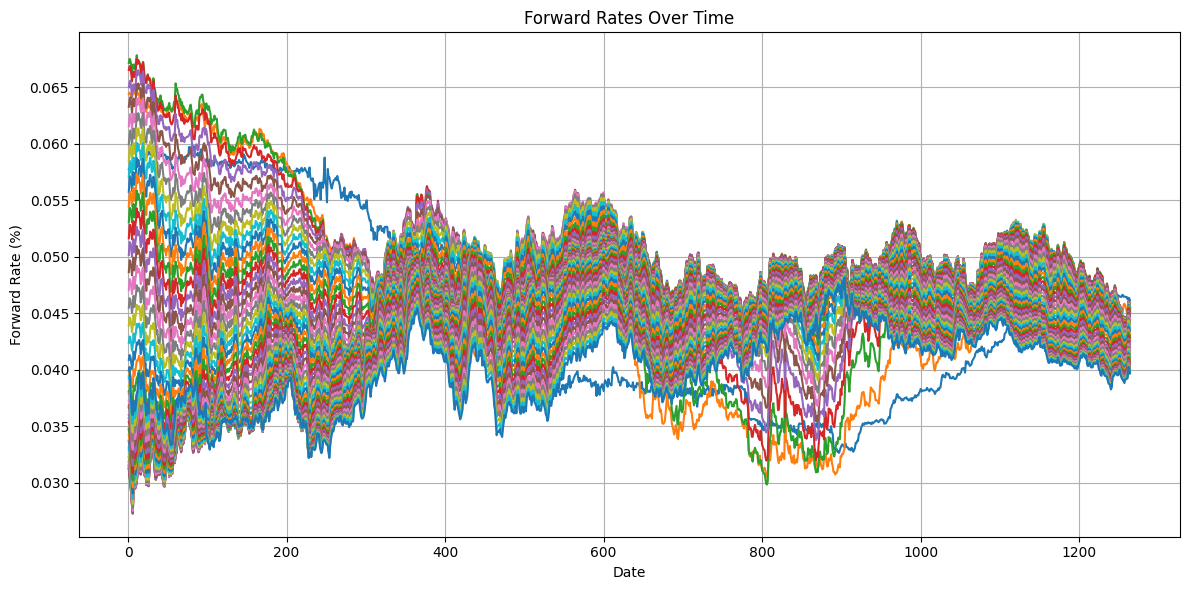

In [5]:
plt.figure(figsize=(12, 6))
for col in fwdrates.columns:
    plt.plot(fwdrates.index, fwdrates[col], label=col)
plt.title("Forward Rates Over Time")
plt.xlabel("Date")
plt.ylabel("Forward Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

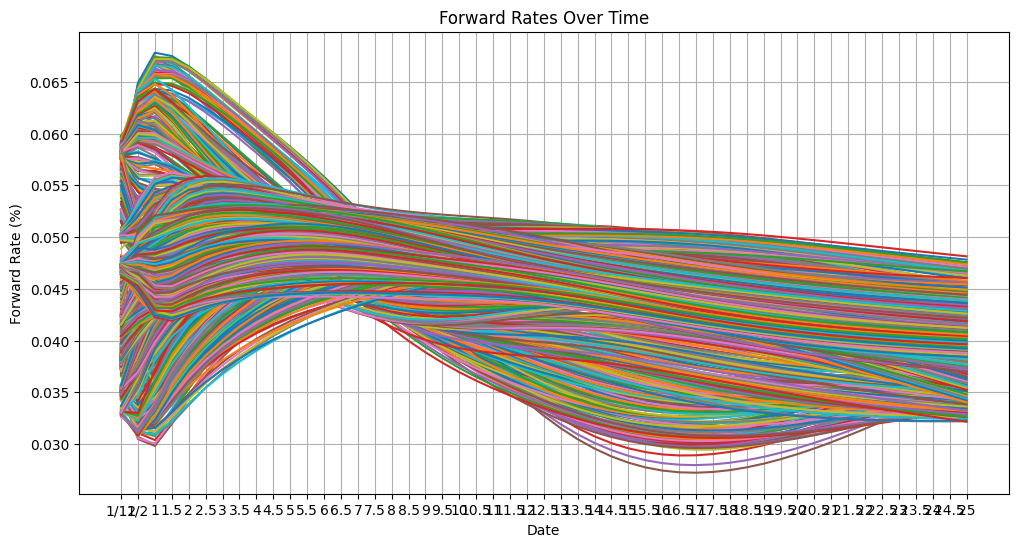

In [6]:
plt.figure(figsize=(12, 6))
fwdrates_transpose= fwdrates.T
for i in fwdrates_transpose.columns:
    plt.plot(fwdrates_transpose.index, fwdrates_transpose[i], label = i)
plt.title("Forward Rates Over Time")
plt.xlabel("Date")
plt.ylabel("Forward Rate (%)")
plt.grid(True)
plt.show()

### Principal Component Analysis

In this part, principal component analysis is applied to scaled rate data to identify key factors driving variations. The proportion of variance explained by each factor is computed and accumulated. The number of factors required to capture at least 95% of the total variance is determined. The corresponding magnitudes and directional factors are then extracted. These components help in efficiently modeling rate dynamics.

eigenvalues :  [0.00202884 0.00046289 0.00016368]


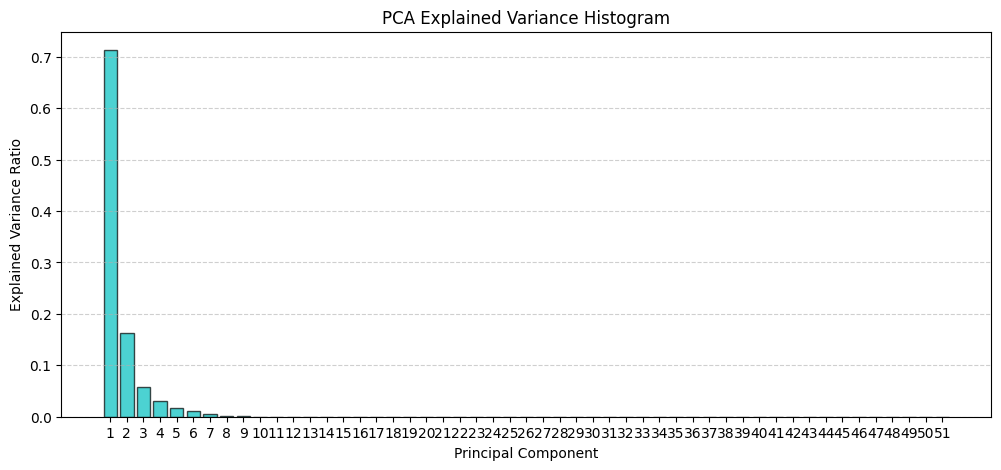

In [7]:
fwdrates_scale = fwdrates.diff()
fwdrates_scale = fwdrates_scale.dropna(axis=0)
pca_features = PCA().fit(fwdrates_scale*np.sqrt(BUSINESS_N_YEAR))
explained_variance = pca_features.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()
num_components = np.argmax(cumulative_variance >= EXPLAIN_LEVEL) + 1
eigenvalues = pca_features.explained_variance_
print("eigenvalues : ", eigenvalues[:num_components])
eigenvectors = pca_features.components_
main_components = pd.DataFrame(data = eigenvectors[:num_components].T, columns = ['PCA_'+(str(i)) for i in range(num_components)])
plt.figure(figsize=(12, 5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, color='c', edgecolor='k', alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance Histogram')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

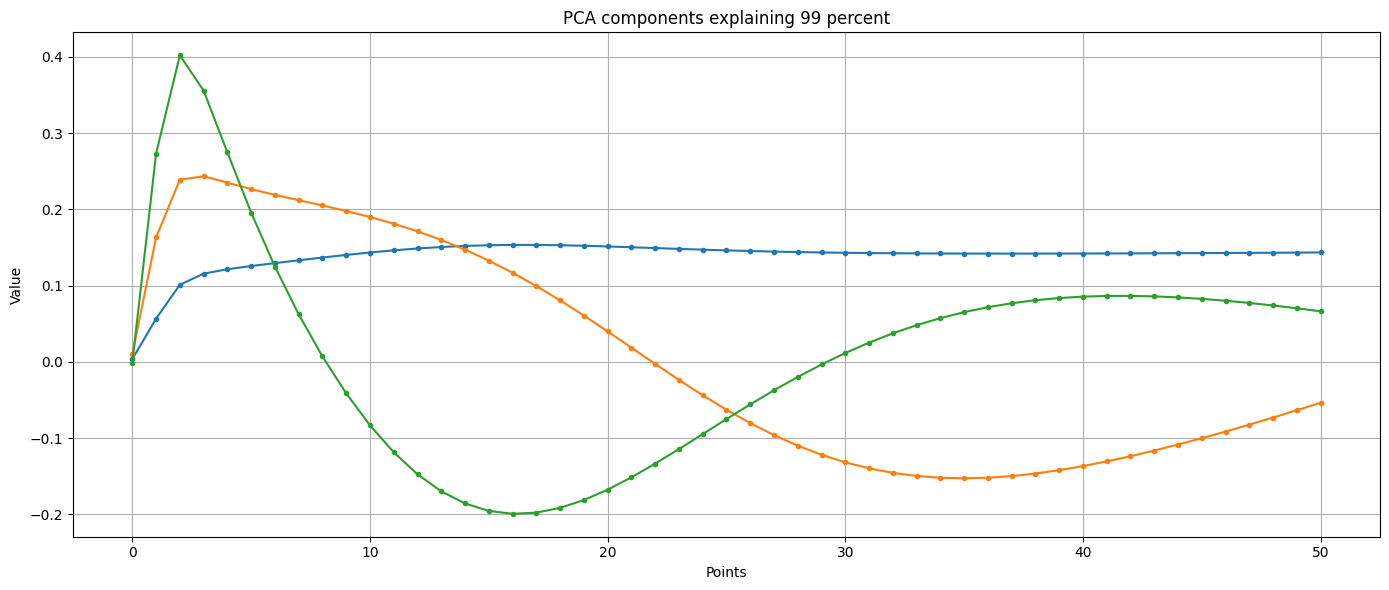

In [8]:
plt.figure(figsize=(14,6))
simulation_tenors = np.linspace(0,50,51)
plt.plot(simulation_tenors, main_components, marker='.')
plt.title('PCA components explaining 99 percent')
plt.xlabel("Points")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

### Volatility structures

We construct smoothed volatility structures from principal components. It derives volatilities by scaling directional factors with their corresponding magnitudes. These volatilities are then interpolated using cubic splines over predefined maturities. The process ensures a smooth representation of how volatilities evolve. The output captures different modes of variation in the data.

In [9]:
volatilitie = []
vol_structure = []
for i in range(num_components):
    volatilitie.append(np.sqrt(eigenvalues[i])*eigenvectors[i])
    vol_structure.append(CubicSpline(tenors, volatilitie[i])) 


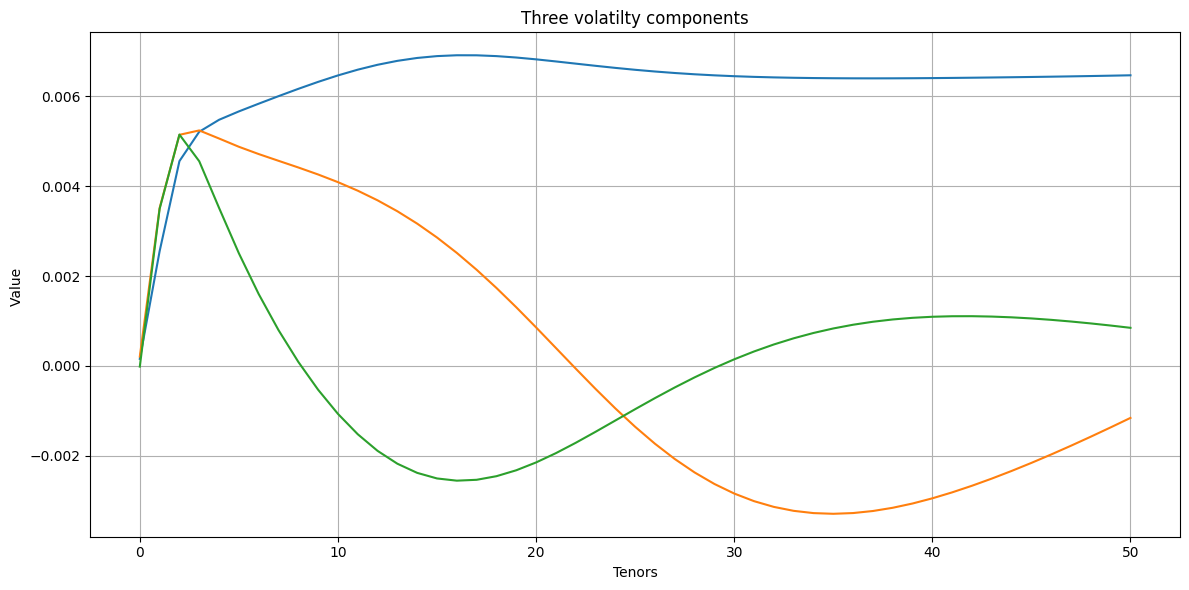

In [10]:
label_structure = ('V1', 'V2','V3')
plt.figure(figsize=(12, 6))
i=0
vols =[]
for item in vol_structure:
    vol = [item(tau) for tau in simulation_tenors]
    vols.append(vol)
    plt.plot(simulation_tenors, vol, label = label_structure[i])
    i = i+1

plt.title("Three volatilty components")
plt.xlabel("Tenors")
plt.ylabel("Value ")
plt.grid(True)
plt.tight_layout()
plt.show()

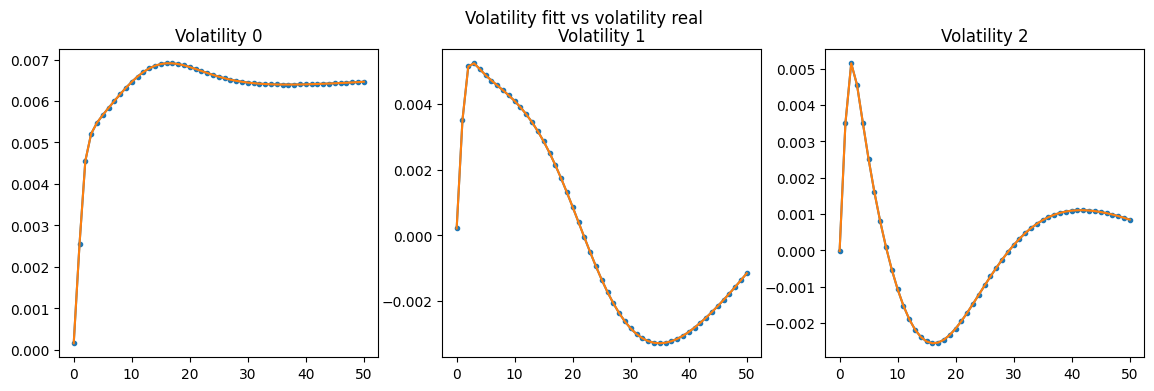

In [11]:
fig, axs = plt.subplots(1, 3,figsize=(14, 4))
fig.suptitle('Volatility fitt vs volatility real')
i = 0
for (vols_real,vol_fit) in zip(volatilitie,vols):
    axs[i].plot(tenors, vols_real, marker='.', label='Discretized volatility')
    axs[i].plot(tenors,vol_fit, label='Fitted volatility')
    axs[i].set_title('Volatility ' +str(i))
    i = i+1
    

### Computation of drifts 

Here we compute the drift term in the HJM framework by summing the volatility components weighted by their integrals over time. Using the extracted volatility structures, we determine the drift for each tenor by integrating the squared volatilities. This ensures consistency with the no-arbitrage condition in interest rate modeling, allowing for accurate Monte Carlo simulations of forward rates.







$$ m(t,T) = \sum_{i=1}^n \sigma_i(t,T) \int_0^T \sigma_i(t,s)ds $$

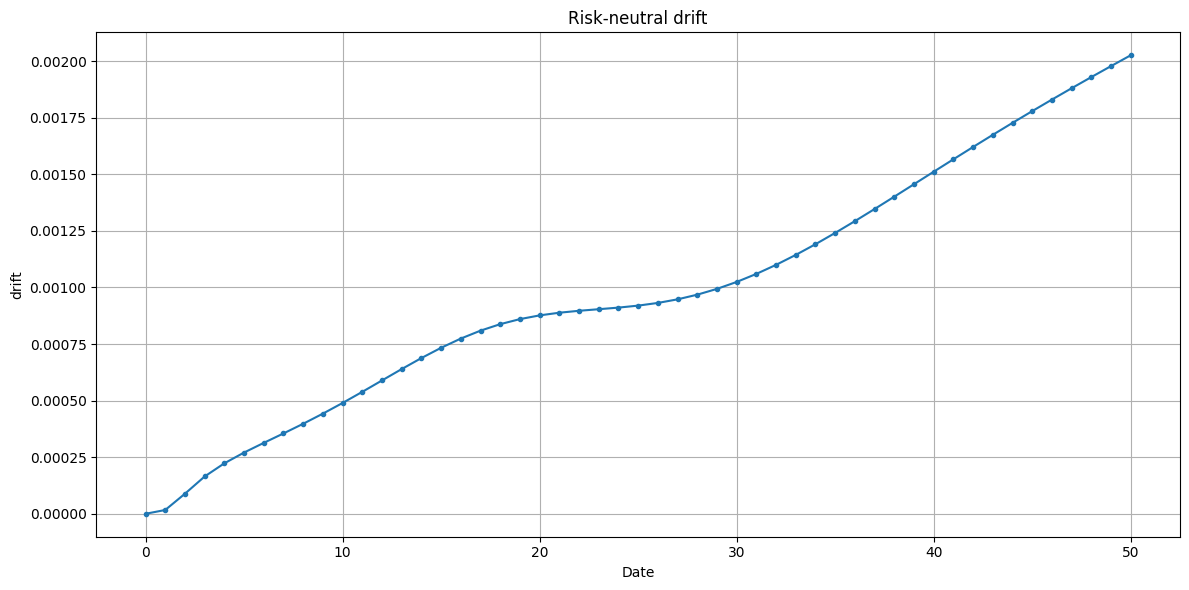

In [12]:
def drift_computation(t,T):
    return sum([vol(T)*vol.integrate(t,T) for vol in vol_structure])

drift = [drift_computation(0,tau) for tau in simulation_tenors]
plt.figure(figsize=(12, 6))
plt.plot(simulation_tenors, drift, marker='.')
plt.title('Risk-neutral drift')
plt.xlabel("Date")
plt.ylabel("drift")
plt.grid(True)
plt.tight_layout()
plt.show()

### Current spot rate

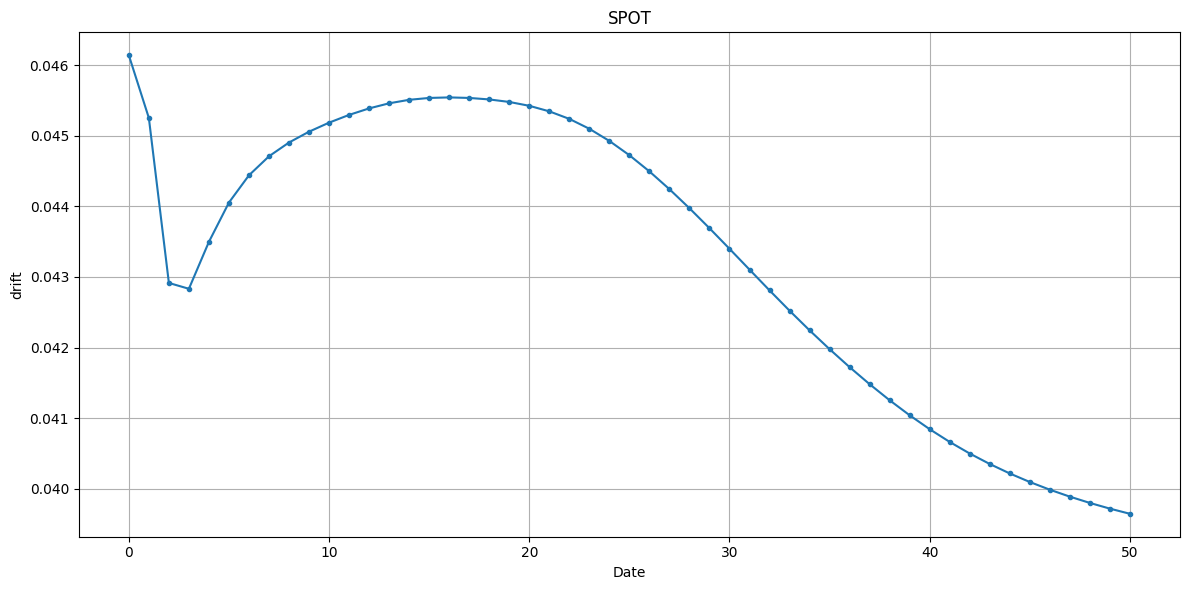

In [13]:
plt.figure(figsize=(12,6))
plt.plot(tenors, spot_rates, marker='.')
plt.title('SPOT')
plt.xlabel("Date")
plt.ylabel("drift")
plt.grid(True)
plt.tight_layout()
plt.show()

### HJM Simulation

Here we simulate the evolution of forward interest rates over time. At each time step, the forward rates are updated using drift terms, volatility contributions, and the local rate of change between adjacent tenors. The process iterates over the tenors, updating each forward rate based on the previous values, and yields the updated rates at each time step in the timeline.











In [14]:
def simulation(forward_rates, tenors, drift_terms, volatility_matrix, timeline):
    #volatility_matrix = np.transpose(volatility_matrix)
    np.random.seed(42)
    yield timeline[0], np.copy(forward_rates)

    # Iterate over the timeline
    for time_index in range(1, len(timeline)):
        time_step = timeline[time_index] - timeline[time_index - 1]
        previous_forward_rates = forward_rates
        forward_rates = np.copy(forward_rates)
        random_shocks = [np.random.standard_normal() for _ in range(len(volatility_matrix))]

        for tenor_index in range(1, len(tenors)):
            # Compute the new value for forward_rates[tenor_index]
            updated_rate = previous_forward_rates[tenor_index] + drift_terms[tenor_index] * time_step

            # Add the contribution from volatility
            updated_rate += sum( np.sqrt(time_step)*factor_volatility[tenor_index] * random_shocks[factor_index] for factor_index, factor_volatility in enumerate(volatility_matrix)
            )
           
            # Add the effect of the local rate of change
            next_tenor_index = tenor_index + 1 if tenor_index < len(tenors) - 1 else tenor_index - 1
            local_rate_of_change = (previous_forward_rates[next_tenor_index] - previous_forward_rates[tenor_index]) / (
                next_tenor_index - tenor_index
            )
            updated_rate += local_rate_of_change * time_step

            forward_rates[tenor_index] = updated_rate

        # Yield the time and updated forward rates
        yield timeline[time_index],forward_rates


### Evolution of Forward Rates Over Time









Here, "$f(t,T)$" refers to how the forward rate, represented by $f(t,T)$, changes over time $t$ for a fixed maturity $T$. It shows how the forward rate evolves as time progresses, with each value of $t$ representing a specific point in time. Essentially, it captures the change in the forward rate for a given maturity as time moves forward.


$f(t,T)$ by $t$'



In [15]:
rates = [x for (t,x) in simulation(spot_rates,tenors,drift,vols, timeline)]
columns = [tn for tn in tenors]
df_rates = pd.DataFrame(rates,index=timeline,columns=columns)
df_rates

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0.00000,0.046138,0.045251,0.042916,0.042833,0.043498,0.044054,0.044440,0.044708,0.044903,0.045057,...,0.040665,0.040501,0.040353,0.040219,0.040098,0.039989,0.039891,0.039802,0.039721,0.039648
0.01002,0.046138,0.045533,0.043405,0.043323,0.043936,0.044437,0.044774,0.045001,0.045160,0.045283,...,0.041108,0.040943,0.040793,0.040657,0.040533,0.040420,0.040318,0.040224,0.040139,0.040060
0.02004,0.046138,0.045736,0.043858,0.043895,0.044577,0.045133,0.045521,0.045795,0.045999,0.046164,...,0.042139,0.041972,0.041820,0.041681,0.041555,0.041440,0.041336,0.041240,0.041153,0.041073
0.03006,0.046138,0.046227,0.044733,0.044916,0.045673,0.046291,0.046735,0.047062,0.047314,0.047521,...,0.042898,0.042743,0.042605,0.042482,0.042373,0.042275,0.042189,0.042113,0.042045,0.041985
0.04008,0.046138,0.046025,0.044505,0.044753,0.045580,0.046263,0.046765,0.047145,0.047446,0.047697,...,0.043338,0.043178,0.043034,0.042905,0.042789,0.042686,0.042593,0.042510,0.042436,0.042370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.95992,0.046138,0.069981,0.074893,0.075128,0.074372,0.073651,0.073160,0.072920,0.072916,0.073129,...,0.088362,0.088164,0.087943,0.087703,0.087447,0.087178,0.086901,0.086619,0.086335,0.086051
4.96994,0.046138,0.069154,0.073684,0.074062,0.073540,0.073043,0.072754,0.072695,0.072855,0.073216,...,0.089178,0.088959,0.088719,0.088458,0.088182,0.087893,0.087596,0.087294,0.086990,0.086686
4.97996,0.046138,0.069060,0.073359,0.073673,0.073146,0.072656,0.072373,0.072316,0.072474,0.072828,...,0.087797,0.087597,0.087376,0.087137,0.086884,0.086620,0.086349,0.086074,0.085798,0.085523
4.98998,0.046138,0.069623,0.074334,0.074792,0.074325,0.073877,0.073633,0.073615,0.073812,0.074205,...,0.089630,0.089423,0.089195,0.088948,0.088687,0.088414,0.088133,0.087848,0.087562,0.087277


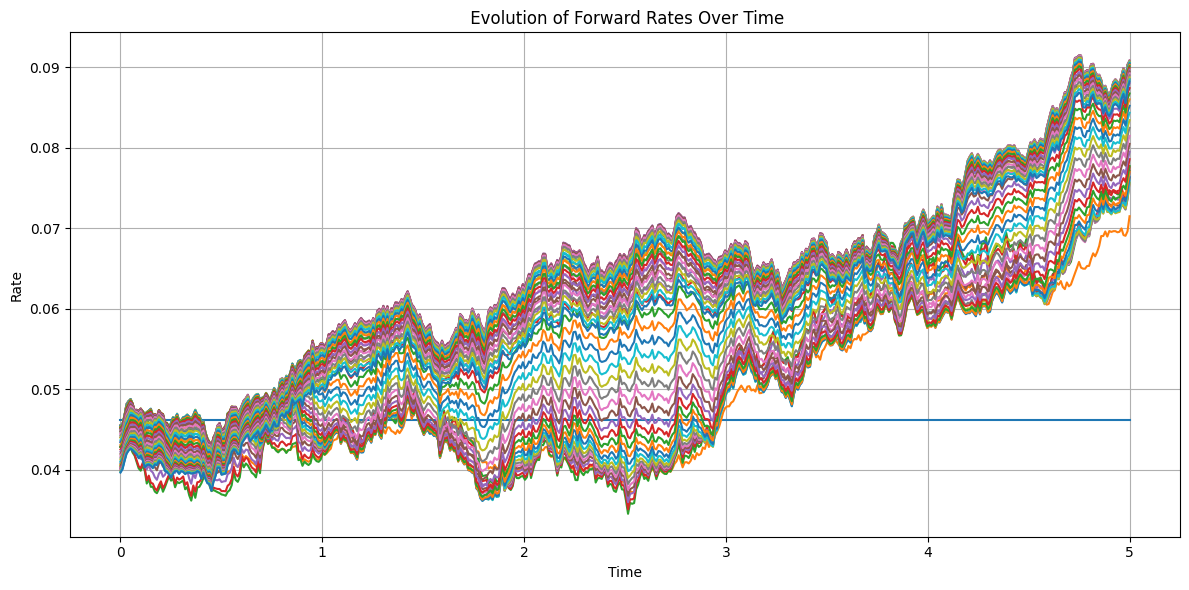

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(timeline,rates)
plt.title(" Evolution of Forward Rates Over Time")
plt.xlabel("Time")
plt.ylabel("Rate")
plt.grid(True)
plt.tight_layout()
plt.show()

### Variation of Forward Rates with Tenor









Here we simulate the forward rate evolution over time. "$f(t,T)$" refers to how the forward rate, denoted by $f(t,T)$, changes with respect to different tenors $T$ for a fixed time $t$. It shows how the forward rate evolves as the maturity $T$ changes, while time $t$ remains constant. In other words, it illustrates how the forward rate varies for different maturities at a specific point in time.










$$f(t,T) , T$$'

In [17]:
df_rates_T = df_rates.T
df_rates_T.head()

,0.00000,0.01002,0.02004,0.03006,0.04008,0.05010,0.06012,0.07014,0.08016,0.09018,...,4.90982,4.91984,4.92986,4.93988,4.94990,4.95992,4.96994,4.97996,4.98998,5.00000
0,0.046138,0.046138,0.046138,0.046138,0.046138,0.046138,0.046138,0.046138,0.046138,0.046138,...,0.046138,0.046138,0.046138,0.046138,0.046138,0.046138,0.046138,0.046138,0.046138,0.046138
1,0.045251,0.045533,0.045736,0.046227,0.046025,0.044795,0.044385,0.044147,0.043591,0.043062,...,0.069543,0.069636,0.069640,0.069496,0.069555,0.069981,0.069154,0.069060,0.069623,0.071491
2,0.042916,0.043405,0.043858,0.044733,0.044505,0.042745,0.042134,0.041752,0.040952,0.040172,...,0.074400,0.074565,0.074504,0.074210,0.074193,0.074893,0.073684,0.073359,0.074334,0.077137
3,0.042833,0.043323,0.043895,0.044916,0.044753,0.043100,0.042431,0.041897,0.041175,0.040437,...,0.074500,0.074736,0.074621,0.074366,0.074340,0.075128,0.074062,0.073673,0.074792,0.077584
4,0.043498,0.043936,0.044577,0.045673,0.045580,0.044146,0.043447,0.042761,0.042180,0.041544,...,0.073610,0.073904,0.073737,0.073564,0.073554,0.074372,0.073540,0.073146,0.074325,0.076909


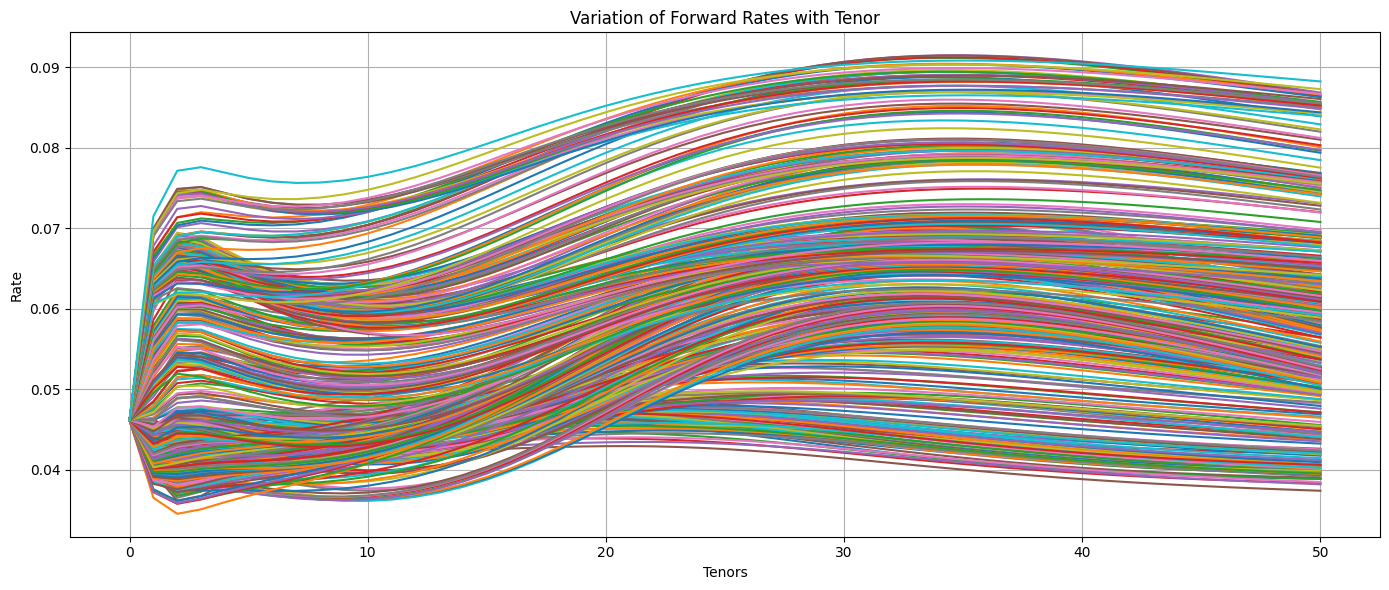

In [18]:
plt.figure(figsize=(14, 6))
plt.plot(df_rates_T.index,df_rates_T )
plt.title("Variation of Forward Rates with Tenor")
plt.xlabel("Tenors")
plt.ylabel("Rate")
plt.grid(True)
plt.tight_layout()
plt.show()